![Astrofisica Computacional](../../../new_logo.png)

## Exercise 1: Data Loading + NumPy Preprocessing

_Note: I deleted the first cell so I have everything more organized_

Load temps from the file "kumpula-weather-2017.csv". Write a function to convert mm-dd to days since start (days = monthday_to_days).

- Filter NaNs or infs/masks.

- Calculate anomalies (temperature - 30-day moving average).

- Detect outliers (IQR method, Q1-1.5*IQR).

**Expected output:** `temps_clean` (N x 2), `dias` (N,).

In [1]:
import numpy as np

### Solution 

**Part 0: read data**

From the .csv file, we know that the 0th, 1st, 2nd and 5th columns are the data we need for year, month, day and air temperature, respectively. We start by reading the data and selecting these columns

In [2]:
# We read the raw data
raw_data = np.genfromtxt("kumpula-weather-2017.csv", delimiter=",", skip_header=1)

# We separate the data given the previous knowledge of the set
year = raw_data[:, 0]
month = raw_data[:, 1]
day = raw_data[:, 2]
T = raw_data[:, -1]


**Part 1: days_since_beginning array**

One could take advantage of the format of the file, as it is one only measure point per day from day 1 to 365 (that is, simply creating a vector with values [1, 2, ... 365]). But for the sake of manipulatibity, we'll create an actual function that will take the year, month and day vectors and output the real days_since_beginning vector 

In [3]:
def days_passed(years, months, days):
    """ 
        Function to convert year, month and day arrays into day_since_beginning 
        Adapted from IA
    """

    # Lenght of the months
    month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    # Where we'll be saving up the info
    result = []

    # Initial date data
    y0 = years[0]
    m0 = months[0]
    d0 = days[0]

    for y, m, d in zip(years, months, days):
        
        # Days from complete years
        year_days = (y - y0) * 365
        
        if y == y0:
            # If a year hasn't passed, then we only have to count the months and days after the initial date
            
            # Days from complete months in current year
            month_days = sum(month_lengths[int(m0)-1:int(m)-1])
        else:
            # If a years passed already, then we have to count the months from the beggining
            month_days = sum(month_lengths[:int(m)-1])

        # Total days passed is then the year days + month days + the current days
        total = year_days + month_days + d

        result.append(total)

    return np.array(result)

days_since_beginning = days_passed(year, month, day)    # The new array

**Part 2**

We can just create the desired data array considering cleaning and formating as suggested

In [4]:
formatted_data = np.array([days_since_beginning, T]).T   # We transpose the data to have the same format as the csv (and because things are always used like this)
mask = np.all(np.isfinite(formatted_data), axis=1)       # Then we create a mask to check for non-numerical values (check if it is a finite float)

data = formatted_data[mask]


**Part 3: check anomalies**

Here, we're asked to check for anomalies using a 30 days window average. This can be easily done by checking the convolution of a 30 days mask.

_Problem:_ on the edges, the convolution does not have entries to evaluate. For that, we'll tell the convolutor (if that's how it's called) to reflect the data on the edge, considering that we hope the same behaviur for future than from previous days with respect to the edges days. 



In [5]:
from scipy.ndimage import convolve1d

N = 30              # The day window
mode_ = "reflect"    # What to do for the edges entries

kernel = np.ones(N) # How we'll take the average (weights of it)

window_averaged_T = convolve1d(data[:,1], kernel, mode=mode_) / N

Now, we'll plot this data and the real data together to check how they differ

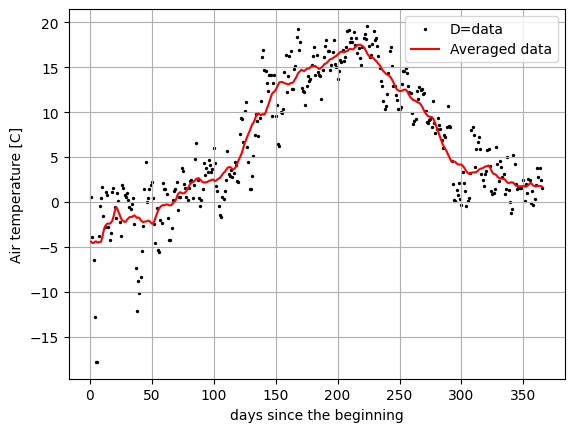

In [6]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], label = "D=data", c = "black", s = 2)
plt.plot(data[:, 0], window_averaged_T, label = "Averaged data", c = "red")

plt.grid()
plt.legend()

plt.xlabel("days since the beginning")
plt.ylabel("Air temperature [C]")

plt.show()

From here, we could infer that, in general, the data is well behaved except for some of the firsts 50 days.

To get rid of these anomalies, we'll delete the rows of data whose temperature is < -5 C and check if this change helped in any way the behavior of the data (from a mere visual analisys) 

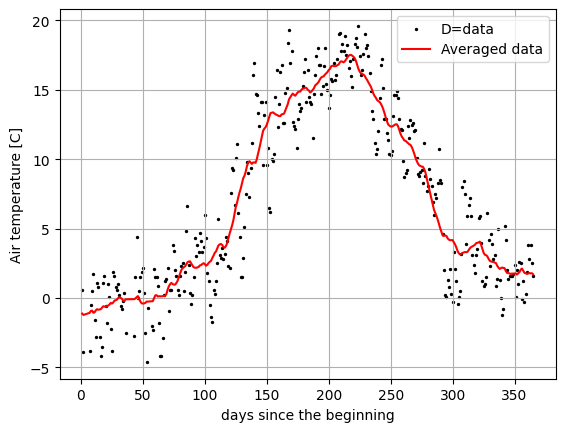

In [7]:
anomalies_mask = data[:, 1] > -5.0       # We create a mask to check if T < -5 C

filtered_anomalies_data = data[anomalies_mask]

window_averaged_T_fa = convolve1d(filtered_anomalies_data[:,1], kernel, mode=mode_) / N

plt.scatter(filtered_anomalies_data[:, 0], filtered_anomalies_data[:, 1], label = "D=data", c = "black", s = 2)
plt.plot(filtered_anomalies_data[:, 0], window_averaged_T_fa, label = "Averaged data", c = "red")

plt.grid()
plt.legend()

plt.xlabel("days since the beginning")
plt.ylabel("Air temperature [C]")

plt.show()

From this, we can see that the data behaves more properly than before just from checking that the filtered data follows more closely the tendency data.

**Part 4: detect outliers**

Now, we'll use the IQR and 1IQ - 1.5IQR methods to detect outliers. 

Something important here is that we're surely working with some sort of seasonal data, this can be seen from the averaged data, where the tendency is not constant but changes almost like an oscilation. With that said, what we'll do is substract from the original data the average tendency, hoping to center the whole data around 0 and getting rid of the seasonal behavior. After that, we'll compute the IQR rule as usual

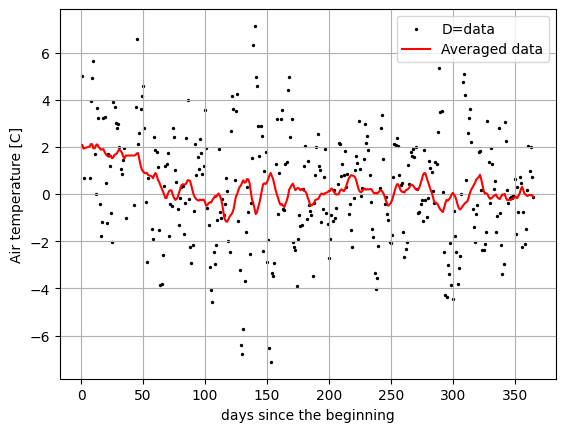

In [28]:
centered_data_T = filtered_anomalies_data[:, 1] - window_averaged_T[anomalies_mask]   # Substract from our data the average found priorly
window_averaged_T_fa = convolve1d(centered_data_T, kernel, mode=mode_) / N            # Just to check the average behavior, we do again the convolution

# Plot the same way as we did before
plt.scatter(filtered_anomalies_data[:, 0], centered_data_T, label = "D=data", c = "black", s = 2)
plt.plot(filtered_anomalies_data[:, 0], window_averaged_T_fa, label = "Averaged data", c = "red")

plt.grid()
plt.legend()

plt.xlabel("days since the beginning")
plt.ylabel("Air temperature [C]")

plt.show()

With this, we can see that we have a way more centered dataset. Now, we can make the IQR analysis

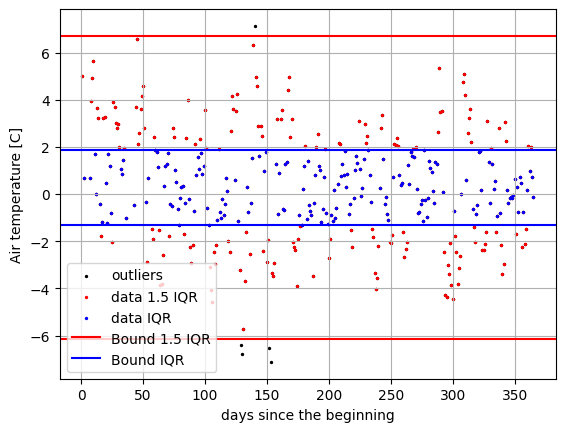

In [24]:
# We take the percentiles
Q1 = np.percentile(centered_data_T, 25)
Q3 = np.percentile(centered_data_T, 75)
IQR = Q3-Q1

# Create the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create the bounds
lower_bound_alt = Q1
upper_bound_alt = Q3

# Create the mask
mask = (centered_data_T >= lower_bound) & (centered_data_T <= upper_bound)
non_outliers_filtered_data = centered_data_T[mask]                             # Apply the mask to the data

mask_alt = (centered_data_T >= lower_bound_alt) & (centered_data_T <= upper_bound_alt)
non_outliers_filtered_data_alt = centered_data_T[mask_alt]                             # Apply the mask to the data



# Plot similarly as before
plt.scatter(filtered_anomalies_data[:, 0], centered_data_T, label = "outliers", c = "black", s = 2)
plt.scatter(filtered_anomalies_data[mask, 0], non_outliers_filtered_data, label = "data 1.5 IQR", c = "red", s = 2)
plt.scatter(filtered_anomalies_data[mask_alt, 0], non_outliers_filtered_data_alt, label = "data IQR", c = "blue", s = 2)


plt.axhline(y=upper_bound, c="red", linestyle='-', linewidth=1.5, label="Bound 1.5 IQR")
plt.axhline(y=lower_bound, c="red", linestyle='-', linewidth=1.5)

plt.axhline(y=upper_bound_alt, c="blue", linestyle='-', linewidth=1.5, label="Bound IQR")
plt.axhline(y=lower_bound_alt, c="blue", linestyle='-', linewidth=1.5)

plt.grid()
plt.legend()

plt.xlabel("days since the beginning")
plt.ylabel("Air temperature [C]")

plt.show()

**Last step: reconstructing the signal**

With what we've done now, we can now reconstruct the whole filtered and well-behaved signal by simply adding the average trending data we substracted some steps ago

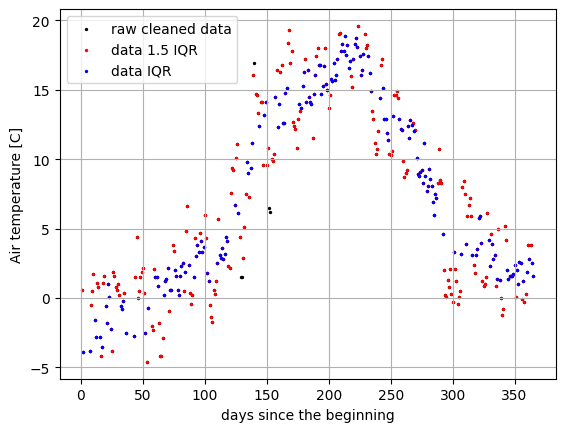

In [35]:
# Because I've done all of this pretty messy, I better create this variable to help me mask the following data
start_filtered_data = window_averaged_T[anomalies_mask]

IQR15_data = np.array([filtered_anomalies_data[mask, 0], non_outliers_filtered_data + start_filtered_data[mask]]).T
IQR_data = np.array([filtered_anomalies_data[mask_alt, 0], non_outliers_filtered_data_alt + start_filtered_data[mask_alt]]).T

# Plot similarly as before
plt.scatter(filtered_anomalies_data[:, 0], filtered_anomalies_data[:, 1], label = "raw cleaned data", c = "black", s = 2)
plt.scatter(IQR15_data[:, 0], IQR15_data[:, 1], label = "data 1.5 IQR", c = "red", s = 2)
plt.scatter(IQR_data[:, 0], IQR_data[:, 1], label = "data IQR", c = "blue", s = 2)

plt.grid()
plt.legend()

plt.xlabel("days since the beginning")
plt.ylabel("Air temperature [C]")

plt.show()


# We'll now save the things that we were asked for
temps_clean = IQR_data[:, 1]
dias = IQR_data[:, 0]

## Exercise 2: Advanced Class with Inheritance/Decorators 

Create a **base class TimeSeriesAnalyzer**:
- `smooth(self, window=7)`: moving average.

- Decorator `@vectorize` to apply functions to columns.

**Child class WeatherAnalyzer** inherits and adds:
- `seasonal_decompose(self)`: trend (polyfit deg=2), seasonal (FFT top 4 freq), residual.

- `forecast(self, days_ahead=30)`: simple ARIMA-like (last 30 days, polyfit deg=3) + noise.

- **Use:** `analyzer = WeatherAnalyzer(days, temps_clean[:,1])`

In [81]:
calls = 1

# Decorator to vectorize method over the columns
def vectorize(method):
    def wrapper(self, *args, **kwargs):
        results = np.array([method(self, col, *args, **kwargs) for col in self.data.T]).T
        return results if results.ndim > 1 else results.flatten()
    return wrapper

class TimeSeriesAnalyzer:
    """Clase base para análisis de series temporales con NumPy."""
    def __init__(self, t: np.ndarray, data: np.ndarray):
        self.t = np.asarray(t)
        self.data = np.asarray(data)
        if self.t.shape[0] != self.data.shape[0]:
            raise ValueError("t y data deben tener misma longitud")
    
    @vectorize
    def smooth(self, col: np.ndarray, window: int = 7, mode: str = 'same') -> np.ndarray:
        """Media móvil con convolve."""
        global calls
        calls += 1
        kernel = np.ones(window) / window
        return np.convolve(col, kernel, mode=mode)
    
    def stats(self) -> dict:
        """Estadísticas básicas por columna."""
        return {
            'mean': np.mean(self.data, axis=0),
            'std': np.std(self.data, axis=0),
            'min': np.min(self.data, axis=0),
            'max': np.max(self.data, axis=0)
        }

class WeatherAnalyzer(TimeSeriesAnalyzer):
    """Hija especializada en datos meteorológicos."""
    def __init__(self, t: np.ndarray, data: np.ndarray):
        super().__init__(t, data)
    
    def seasonal_decompose(self, degree_trend: int = 2, n_freqs: int = 4) -> dict:
        """Descomposición: trend (polyfit), seasonal (FFT top freqs), residual."""
        # Trend: polyfit global
        p_trend = np.polynomial.Polynomial.fit(self.t, self.data, degree_trend)
        trend = p_trend(self.t)
        
        # Seasonal: FFT, top n_freqs armónicos
        fft = np.fft.fft(self.data - trend, axis=0)
        freqs = np.fft.fftfreq(len(self.t))
        top_idx = np.argsort(np.abs(fft), axis=0)[-n_freqs:][::-1]
        seasonal = np.zeros_like(self.data)
        for idx in top_idx[:]:
            seasonal[:] += 2 * np.real(np.fft.ifft(fft[:] * (np.abs(fft[idx]) > 1e-3)))
        
        residual = self.data - trend - seasonal
        return {'trend': trend, 'seasonal': seasonal, 'residual': residual}
    
    def forecast(self, days_ahead: int = 30, degree: int = 3, noise_std: float = 1.0) -> tuple:
        """Pronóstico simple: polyfit últimos datos + ruido gaussiano."""
        n_last = min(degree * 10, len(self.t) // 2)
        t_last = self.t[-n_last:]
        data_last = self.data[-n_last:]
        
        t_future = np.linspace(self.t[-1], self.t[-1] + days_ahead, days_ahead)
        forecast = np.zeros(days_ahead) #np.zeros((days_ahead, self.data.shape[1]))
        
        p = np.polyfit(t_last, data_last[:], degree)
        forecast[:] = np.polyval(p, t_future) + np.random.normal(0, noise_std, days_ahead)
        
        return t_future, forecast

# DEMO de USO (¡ejecuta después de Ej.1!)
analyzer = WeatherAnalyzer(IQR_data[:, 0], IQR_data[:, 1])

# analyzer = WeatherAnalyzer(filtered_anomalies_data[:, 0], filtered_anomalies_data[:, 1])

smoothed = analyzer.smooth(window=15)
print(f"call {calls}")

decomp = analyzer.seasonal_decompose()
t_fc, fc = analyzer.forecast(30)
print(analyzer.stats())

call 178
{'mean': 7.6768361581920885, 'std': 6.59280339891701, 'min': -3.9, 'max': 18.9}


## Exercise 3: Robust I/O + Processed 

- Save `temps_clean` + `anomalies` to 'processed_weather.npz' (np.savez).

- Write subset (first 100 days, columns: days, temp_smooth, anomaly) to 'subset.csv' (savetxt, fmt='%.2f', header).

- Function `load_and_validate(filename)`: loads npz/csv, checks shape/inf/NaNs, returns a dictionary.

In [73]:
anomalies = start_filtered_data[mask_alt]
np.savez('processed_weather.npz', temps=temps_clean, anomalies=anomalies)
subset = np.column_stack([dias[:100], smoothed[0,:100], anomalies[:100]])
np.savetxt('subset.csv', subset, delimiter=',', header='day,temp_smooth,anomaly', fmt='%.3f')

def load_and_validate(filename):
    
    if filename[-3:] == "npz":
        print("npz read")
        data = np.load(filename)
        data_dict = {key: arr for key, arr in data.items()}
    elif filename[-3:] == "csv":
        print("csv read")
        data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None,)
        data_dict = {name: data[name] for name in data.dtype.names}
        
    return data_dict


# load_and_validate('processed_weather.npz')
# load_and_validate('subset.csv')

# Some Questions:

- For outliers (IQR method): what fraction of data is removed? Is this conservative/aggressive? Propose alternative (e.g., sigma=3).
- Trace @vectorize execution: for data.shape=(365,2), how many calls to smooth(col)? Why results.T? What other vectorizing method you propose?
- In seasonal_decompose(): why subtract trend before FFT? What do top-4 frequencies represent (daily/weekly/monthly/yearly)?
- Run analyzer.stats() on raw vs smoothed: % std reduction per column? Why does polyfit deg=2 capture trend well?

1. Depends a lot on which IQR we're using. If we choose the usual 1.5IQR, then not really much data is removed, only around 10 points in total are removed. While if we use the more aggresive IQR, much more tdata is removed, around the expected 50% of the data.

2. That vectorized wrapper is doing literally nothing, probably because of how it is calling the method() function by using list comphrenhension (whatever it is spelled :,) ) If we take the smooth function and use the np.vectorize function and passed to it the columns to work with, it would work better. And I guess we're trasposing the vector to make it a column vector so it keeps the same format as the input.

3. I think it is exactly what I did at the beggining: we want to get rid of the seasonal trend (big oscilatory behaviour) so we have to center our data around 0.0 before the FFT.

4. Not necessarily, the std keeps around the same. What changes a lot is the overall mean, min and max. And poly 2 captures the trend well because the data does look a little like a parabola, eben though it is not necessarily one.